# Implementación de NAS usando la paquetería NNI
**Elaborado por: Alondra E. Matos Mendoza**

Los componentes del proceso de Búsqueda Automática de Arquitecturas Neuronales (NAS) son:

- **<p style="color:purple;">Definición del Espacio de Búsqueda:</p>** Define un espacio de búsqueda que incluye diversos componentes arquitectónicos, como tipos de capas, patrones de conectividad e hiperparámetros. Este espacio representa el conjunto de posibles arquitecturas de redes neuronales.<br> <br/>

- **<p style="color:purple;">Algoritmo de Búsqueda:</p>** Utiliza un algoritmo de búsqueda para recorrer eficientemente el espacio de búsqueda. Los métodos populares incluyen algoritmos genéticos, aprendizaje por refuerzo, búsqueda aleatoria y optimización basada en gradientes. El algoritmo explora diferentes arquitecturas y evalúa su rendimiento en una tarea específica.<br> <br/>

- **<p style="color:purple;">Evaluación del desempeño:</p>** Entrena y valida cada arquitectura en el espacio de búsqueda en una tarea proxy o un conjunto de datos más pequeño para estimar su rendimiento. Este paso implica entrenar, evaluar y comparar múltiples arquitecturas.



La paquetería [NNI de Microsoft](https://nni.readthedocs.io/en/latest/index.html#) simplifica la implementación de técnicas de NAS en el entorno individual, disminuyendo significativamente la carga de trabajo de ingeniería necesaria.

A continuación, se presenta una aplicación de técnicas de NAS utilizando NNI, con el objetivo de descubrir una arquitectura de red neuronal convolucional que logre clasificar las imágenes de la base de datos Fashion MNIST con un desempeño destacado.

Cabe mencionar que es necesario instalar la librería NNI, como se muestra en la siguiente línea de código.

In [1]:
# !pip install nni

### Ejemplo: Fashion MNIST

Fashion-MNIST es una base de datos que contiene imágenes de artículos de Zalando, compuesta por 60,000 ejemplos para entrenamiento y 10,000 para pruebas. Cada ejemplo consiste en una imagen en escala de grises de 28x28 píxeles y una etiqueta asociada perteneciente a una de las siguientes 10 clases disponibles:

| Clase | Descripción | 
|:--------------------:|:-------------------:|
| 0          | T-shirt/top      | 
| 1          | Trouser         |
| 2           | 	Pullover           |
| 3           | Dress       | 
| 4          |	Coat          |
| 5          |	Sandal          |
| 6            | 	Shirt        |
| 7           | Sneaker        | 
| 8            | Bag          |
| 9            | 	Ankle boot         |


###  <p style="color:blue;">Función de evaluación del desempeño: </p>

#####  <p style="color:rgb(135,206,235);">Descripción del espacio de búsqueda:</p>

- **<p style="color:violet;">Definición del Modelo</p>**

Se define el espacio de búsqueda creando una clase que hereda de `ModelSpace`

- **<p style="color:violet;">Capas Convolucionales</p>**

Se definen tres conjuntos de capas convolucionales (`conv1`, `conv2`, `conv3`) utilizando la clase `nn.Sequential`.
Cada conjunto incluye capas convolucionales, capas de normalización por lotes (BatchNorm), y funciones de activación ReLU.
Las capas `MutableConv2d` y `MutableBatchNorm2d` de NNI permiten la modificación automática de la arquitectura durante la búsqueda de la mejor configuración. La arquitectura final puede variar según las elecciones realizadas durante la búsqueda automática.

- **<p style="color:violet;">Bloques y Capa de Elección</p>**

Se define un bloque repetitivo (`blocks4`) con capas convolucionales y de normalización por lotes. La cantidad de repeticiones es determinada por la elección de `nni.choice('num_block', [1, 2, 3])`.

Se define una capa de elección (`conv5`) que selecciona entre dos opciones de capas convolucionales: una capa de convolución depthwise separable y una capa convencional de convolución.

- **<p style="color:violet;">Capas Totalmente Conectadas y Dropout</p>**

Se definen dos capas totalmente conectadas (`fc1` y `fc2`) con dimensiones variables basadas en la elección de `feature` (64, 128, o 193).

La capa de dropout mutable (`dropout1`) ajusta dinámicamente la tasa de dropout con `nni.choice('dropout', [0.25, 0.5, 0.75])`, mientras que `dropout2` tiene una tasa fija del 0.5.

- **<p style="color:violet;">Método Forward</p>**

Se implementa el método `forward` que describe cómo los datos se propagan a través del modelo, aplicando las capas definidas en las secciones anteriores en una secuencia específica.


In [2]:
import nni
import torch
import torch.nn as nn
import torch.nn.functional as F
from nni.nas.nn.pytorch import LayerChoice, ModelSpace, MutableDropout, MutableLinear, MutableConv2d, MutableBatchNorm2d
from nni.nas.nn.pytorch import Repeat

#  Se define un módulo de convolución separable en profundidad
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.depthwise = nn.Conv2d(in_ch, in_ch, kernel_size=3, groups=in_ch)
        self.pointwise = nn.Conv2d(in_ch, out_ch, kernel_size=1)

    def forward(self, x):
        return self.pointwise(self.depthwise(x))

# Espacio de búsqueda
class CreatedModelSpace(ModelSpace):
    def __init__(self):
        super().__init__()
        
        # Primer conjunto de capas convolucionales 
        self.conv1 = nn.Sequential(
            MutableConv2d(1, 32, kernel_size=3, padding=1),
            MutableBatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            MutableBatchNorm2d(64),
            nn.ReLU(),
        )
        
        # Segundo conjunto de capas convolucionales 
        self.conv2 = nn.Sequential(
            MutableConv2d( 64, 64, kernel_size=3, padding=1, bias=False),
            MutableConv2d(64, 64, kernel_size=3, padding=1, bias=False),
            MutableBatchNorm2d(64),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Tercer conjunto de capas convolucionales 
        self.conv3 = nn.Sequential(
            MutableConv2d(64, 128, kernel_size=3, padding=1),
            MutableBatchNorm2d(128),
            nn.ReLU(),
            
            LayerChoice([
            
                nn.Sequential(
                    MutableConv2d(128, 128, kernel_size=3, padding=1),
                    MutableConv2d(128, 256, kernel_size=3, padding=1)),
                
                  MutableConv2d(128, 256, kernel_size=3, padding=1)
     
            ], label='conv3'),
     
            MutableBatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
      
        )        
        
        # Cuarto conjunto de capas convolucionales 
        self.blocks4 = Repeat(
            nn.Sequential(
            MutableConv2d(256, 256, 2, stride=1, padding=1, bias=True),
            MutableBatchNorm2d(256),
            nn.ReLU(inplace=False)) , nni.choice('num_block',[1,2,3]))
        
        # Quinto conjunto de capas convolucionales 
        self.conv5 = LayerChoice([
            nn.Conv2d(256, 512, 3, 1),
            DepthwiseSeparableConv(256, 512)
        ], label='conv5')
        
        
        # Capas totalmente conectadas
        feature = nni.choice('feature', [64, 128, 193 ])
        self.fc1 = MutableLinear(4608, feature)
        self.fc2 = MutableLinear(feature, 10)    
        
        #  Dropouts
        self.dropout1 = MutableDropout(nni.choice('dropout', [0.25, 0.5, 0.75]))  
        self.dropout2 = nn.Dropout(0.5)
        
    
    def forward(self, x):
    # Define cómo los datos se propagan a través del modelo.
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.blocks4(x)
        x = F.avg_pool2d( self.conv5(x), 2)
        x = torch.flatten(self.dropout1(x), 1)
        x = self.fc2(self.dropout2(F.relu(self.fc1(x))))
        output = F.log_softmax(x, dim=1)
        return output

model_space = CreatedModelSpace()
model_space

CreatedModelSpace(
  (conv1): Sequential(
    (0): MutableConv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
    (1): MutableBatchNorm2d(num_features=32)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MutableBatchNorm2d(num_features=64)
    (5): ReLU()
  )
  (conv2): Sequential(
    (0): MutableConv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, bias=False)
    (1): MutableConv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, bias=False)
    (2): MutableBatchNorm2d(num_features=64)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): MutableConv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
    (1): MutableBatchNorm2d(num_features=128)
    (2): ReLU()
    (3): LayerChoice(
      label='conv3'
      (0): Sequential(
        (0): MutableConv2d(in_channels=128, out_channels=128, kernel_size=3, paddin

###  <p style="color:blue;">Función de evaluación</p>
Se define la función de evaluación `evaluate_model`, la cual realiza el proceso completo de entrenamiento (mediante `train_epoch`) y evaluación (mediante `val_epoch`)  a lo largo de un número especificado de épocas, utilizando dataloaders para cargar conjuntos de datos de entrenamiento y validación. 

Durante una época, la función `train_epoch` se encarga de entrenar el modelo, utilizando la función de pérdida de entropía cruzada y el optimizador Adam; mientras que `val_epoch` evalúa el modelo en el conjunto de validación, calculando la exactitud y la pérdida promedio por imagen. 

In [3]:
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader

# Definición de la función para entrenar durante una época
def train_epoch(model, device, train_loader, optimizer, epoch):
    
    loss_fn = torch.nn.CrossEntropyLoss()   # Definir la función de pérdida (entropía cruzada)
    model.train() # Establecer el modelo en modo de entrenamiento

    # Iterar sobre los lotes de datos en el conjunto de entrenamiento
    for batch_idx, (data, target) in enumerate(train_loader):
 
        data, target = data.to(device), target.to(device) # Mover los datos y las etiquetas al dispositivo (CPU o GPU)
        optimizer.zero_grad()  # Inicializar los gradientes del optimizador
        output = model(data) # Hacer una propagación hacia adelante (forward pass)
        loss = loss_fn(output, target) # Calcular la pérdida entre las predicciones y las etiquetas reales
        loss.backward() # Realizar una propagación hacia atrás (backward pass)
        optimizer.step()  # Actualizar los parámetros del modelo utilizando el optimizador

        # Imprimir información de entrenamiento cada 10 lotes
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))



# Definición de la función para evaluar el modelo en el conjunto de validación
def val_epoch(model, device, val_loader):
    model.eval() # Establecer el modelo en modo de evaluación

    # Inicializar la pérdida y el contador de predicciones correctas
    val_loss = 0
    correct = 0

    # Deshabilitar el cálculo de gradientes durante la evaluación
    with torch.no_grad():
        # Iterar sobre los lotes de datos en el conjunto de validación
        for data, target in val_loader:
           
            data, target = data.to(device), target.to(device) # Mover los datos y las etiquetas al dispositivo (CPU o GPU)
            output = model(data)   # Hacer una propagación hacia adelante (forward pass)
            pred = output.argmax(dim=1, keepdim=True) # Obtener las predicciones
            correct += pred.eq(target.view_as(pred)).sum().item() # Actualizar el contador de predicciones correctas

    val_loss /= len(val_loader.dataset) # Calcular la pérdida promedio por imagen en el conjunto de validación
    accuracy = 100. * correct / len(val_loader.dataset) # Calcular la exactitud en el conjunto de validación

    # Imprimir la precisión en el conjunto de validación
    print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
          correct, len(val_loader.dataset), accuracy))

    # Devolver la precisión como medida de desempeño
    return accuracy



# Definición de la función para evaluar el modelo con entrenamiento y validación
def evaluate_model(model):
    # Verificar si la GPU está disponible y configurar el dispositivo
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)

    # Inicializar el optimizador (Adam) con una tasa de aprendizaje de 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 
    
    # Definir la transformación para convertir las imágenes a tensores
    transf = transforms.Compose([transforms.ToTensor()])
    
    # Crear un DataLoader para el conjunto de entrenamiento
    train_loader = DataLoader(
        FashionMNIST(root="data", train=True, download=True, transform=transf),
        batch_size=64, shuffle=True
    )
    
    # Crear un DataLoader para el conjunto de validación
    val_loader = DataLoader(
        FashionMNIST(root="data", train=False, download=True, transform=transf),
        batch_size=64
    )
    
    # Iterar sobre un número especificado de épocas (3 en este caso)
    for epoch in range(3):
        # Entrenar el modelo durante una época
        train_epoch(model, device, train_loader, optimizer, epoch)
        
        # Evaluar el modelo en el conjunto de validación durante una época
        accuracy = val_epoch(model, device, val_loader)
        
        # Informar el resultado intermedio a NNI (Neural Network Intelligence)
        nni.report_intermediate_result(accuracy)

    # Informar el resultado final de la prueba a NNI
    nni.report_final_result(accuracy)


Cuando se crea la funcón de evaluación, se debe guardar usando la función `FunctionalEvaluator`, con el fin de encapsular el código de entrenamiento y evaluación con una única función.Esta función debería recibir una única clase de modelo y utilizar `nni.report_final_result` para informar la puntuación final de este modelo.

In [4]:
from nni.nas.evaluator import FunctionalEvaluator
evaluator = FunctionalEvaluator(evaluate_model)

###  <p style="color:blue;">Algoritmo de Búsqueda </p>

Hay dos enfoques para explorar el espacio de modelos: la estrategia de múltiples intentos y la estrategia de un solo intento. La estrategia de múltiples intentos implica entrenar de manera independiente cada modelo muestreado en el espacio. En cambio, la estrategia de un solo intento implica muestrear el modelo desde un supermodelo.

En este caso, se utilizará un enfoque de múltiples intentos bajo la clase `RegularizedEvolution`, que representa un algoritmo de evolución regularizada, también denominado evolución por envejecimiento. Este algoritmo se fundamenta en el "Algoritmo 1" delineado por Real y colaboradores en "Regularized Evolution for Image Classifier Architecture Search", con ciertas mejoras incorporadas.

Las muestras en el algoritmo se llaman "individuos". Inicialmente, los individuos de la población inicial se muestrean aleatoriamente desde el espacio de búsqueda, mientras que los restantes se generan mediante un proceso de selección y mutación. A medida que se incorporan nuevos individuos a la población, se elimina el más antiguo para mantener constante el tamaño poblacional.

Los parámetros de la clase incluyen:


- *<font color="gray">  population_size (int): </font>* El número de individuos a mantener en la población. Default: 100.

- *<font color="gray"> sample_size (int):</font>* El número de individuos que participarán en cada torneo. Durante la mutación, se pueden seleccionar aleatoriamente sample_size individuos de la población, y el mejor entre ellos se tratará como el padre. Default: 25.

- *<font color="gray">mutation_prob (float):</font>* Probabilidad de que ocurra una mutación en cada dimensión. Default: 0.05.

- *<font color="gray">crossover (bool):</font>* Si es True, el nuevo individuo será el resultado de un cruce entre los ganadores de dos torneos individuales. Es decir, se seleccionarán aleatoriamente dos conjuntos de sample_size individuos de la población, y el mejor de cada conjunto se utilizará como padres. Cada dimensión se seleccionará aleatoriamente de uno de los padres. Default: False.

- *<font color="gray">dedup (bool): </font>* Aplica la restricción de que una muestra no debe aparecer dos veces. La población podría ser más pequeña que population_size si esto se establece en True y el espacio de búsqueda es pequeño. Default: True.

- *<font color="gray">seed  (int | None) : </font>* Semilla aleatoria para la reproducibilidad. Default: None

Si el parámetro crossover es verdadero (True), se seleccionan dos padres (parent1 y parent2) llamando al método best_parent. Estos dos padres son utilizados para realizar un cruce (crossover) aleatorio, donde cada dimensión del individuo resultante tiene un 50% de probabilidad de ser heredada de uno de los padres.Si los dos padres tienen conjuntos diferentes de claves (keys), se lanza un error de valor (ValueError).

Posteriormente, se realiza una mutación en el individuo resultante del cruce o en el individuo padre si no hay cruce (crossover es False). La mutación se realiza para cada dimensión del individuo con una probabilidad dada por el parámetro mutation_prob. Si la mutación ocurre, el valor en esa dimensión se reemplaza por un nuevo valor aleatorio generado a partir del espacio de búsqueda definido por MutableAnnotation.

Si la deduplicación (dedup) está habilitada, se verifica si la nueva muestra generada es una duplicada de alguna muestra existente. Si es así, se rechaza y se lanza un error.

In [5]:
from nni.nas.strategy import RegularizedEvolution
#strategy_RE= RegularizedEvolution(population_size=30, sample_size=10, mutation_prob=0.05, crossover=False)  
strategy_RE= RegularizedEvolution(population_size=30, sample_size=10, mutation_prob=0.05, crossover=True)  

###  <p style="color:blue;">Experimento </p>
Se crea el experimento. Se puede visualizar en el puerto que se configure en `experiment.run.`

In [6]:
#evaluate_model(model_space)

In [7]:
import time
from nni.nas.experiment import NasExperiment
# Inicia el experimento, comienza el proceso de búsqueda.
start_time = time.time()
experiment = NasExperiment(model_space,  evaluator , strategy_RE)
#experiment.config.max_experiment_duration = '10m' # Duración máxima del experimento
experiment.config.max_trial_number = 6   # Generar 6 pruebas como máximo
experiment.run(port=8081)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Tiempo de corrida: {elapsed_time} segundos")

for model_dict in experiment.export_top_models(formatter='dict'):
    print(model_dict)

[2023-12-05 15:32:13] Config is not provided. Will try to infer.
[2023-12-05 15:32:13] Using execution engine based on training service. Trial concurrency is set to 1.
[2023-12-05 15:32:13] Using simplified model format.
[2023-12-05 15:32:13] Using local training service.
[2023-12-05 15:32:15] Creating experiment, Experiment ID: yvetcgpx
[2023-12-05 15:32:15] Starting web server...
[2023-12-05 15:32:17] Setting up...
[2023-12-05 15:32:17] Web portal URLs: http://169.254.97.113:8081 http://169.254.134.255:8081 http://169.254.37.69:8081 http://192.168.1.3:8081 http://169.254.159.4:8081 http://127.0.0.1:8081
[2023-12-05 15:32:17] Successfully update searchSpace.
[2023-12-05 15:32:17] Checkpoint saved to C:\Users\Alondra\nni-experiments\yvetcgpx\checkpoint.
[2023-12-05 15:32:17] Experiment initialized successfully. Starting exploration strategy...
[2023-12-05 15:32:17] Spawning the initial population. 30 individuals to go.
[2023-12-05 15:32:17] [Individual    1] Random: {'conv3': 1, 'num_b

###  <p style="color:orange;">Considerando un espacio de búsqueda definido: NasBench201...</p>

In [8]:
# Definición de la función para evaluar el modelo con entrenamiento y validación
def evaluate_model_3c(model):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 
    
    # Definir la transformación para convertir las imágenes a tensores 
    transf = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor()])
    
    # Crear un DataLoader para el conjunto de entrenamiento
    train_loader = DataLoader(FashionMNIST(root="data", train=True, download=True, transform=transf),batch_size=64, shuffle=True)
    
    # Crear un DataLoader para el conjunto de validación
    val_loader = DataLoader(FashionMNIST(root="data", train=False, download=True, transform=transf),batch_size=64)
    
    # Iterar sobre un número especificado de épocas (3 en este caso)
    for epoch in range(3):
        train_epoch(model, device, train_loader, optimizer, epoch)
        accuracy = val_epoch(model, device, val_loader)
        nni.report_intermediate_result(accuracy)

    # Informar el resultado final de la prueba a NNI
    nni.report_final_result(accuracy)

from nni.nas.evaluator import FunctionalEvaluator
evaluator_3c = FunctionalEvaluator(evaluate_model_3c)

In [10]:
# Espacio de búsqueda
from nni.nas.hub.pytorch import NasBench201
model_space_nasbench = NasBench201(num_labels =10, num_modules_per_stack =5, stem_out_channels =  16)

# Estrategia
from nni.nas.strategy import RegularizedEvolution
strategy_RE2= RegularizedEvolution(population_size=30, sample_size=10, mutation_prob=0.05, crossover=True)  

# Experimento
start_time = time.time()
experiment = NasExperiment(model_space_nasbench,  evaluator_3c, strategy_RE2) # Experimentp
#experiment.config.max_experiment_duration = '10m' # Duración máxima del experimento
experiment.config.max_trial_number = 6   # Generar 4 pruebas como máximo
experiment.run(port=8084)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Tiempo de corrida: {elapsed_time} segundos")

# Imprimir mejor modelo
for model_dict in experiment.export_top_models(formatter='dict'):
    print(model_dict)

[2023-12-05 18:56:24] Config is not provided. Will try to infer.
[2023-12-05 18:56:24] Using execution engine based on training service. Trial concurrency is set to 1.
[2023-12-05 18:56:24] Using simplified model format.
[2023-12-05 18:56:24] Using local training service.
[2023-12-05 18:56:26] Creating experiment, Experiment ID: dgswfh72
[2023-12-05 18:56:26] Starting web server...
[2023-12-05 18:56:27] Setting up...
[2023-12-05 18:56:28] Web portal URLs: http://169.254.97.113:8084 http://169.254.134.255:8084 http://169.254.37.69:8084 http://192.168.1.3:8084 http://169.254.159.4:8084 http://127.0.0.1:8084
[2023-12-05 18:56:28] Successfully update searchSpace.
[2023-12-05 18:56:28] Checkpoint saved to C:\Users\Alondra\nni-experiments\dgswfh72\checkpoint.
[2023-12-05 18:56:28] Experiment initialized successfully. Starting exploration strategy...
[2023-12-05 18:56:28] Spawning the initial population. 30 individuals to go.
[2023-12-05 18:56:28] [Individual    1] Random: {'cell/0_1': 'avg_p

###  <p style="color:orange;">Comparación con autokeras....</p>

Visualización de la base de datos:

[6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]


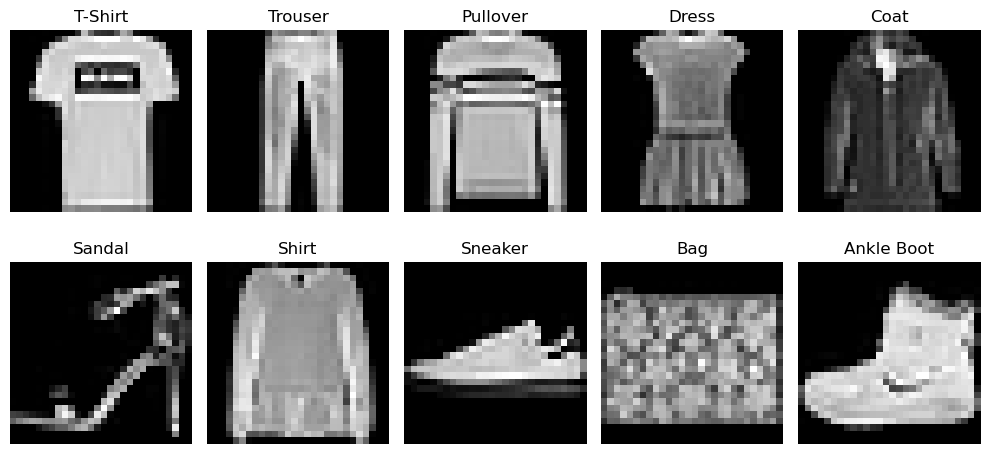

In [13]:
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
import numpy as np

# Cargar el conjunto de datos Fashion MNIST
(train_images, train_labels), (_, _) = fashion_mnist.load_data()

# Calcular la frecuencia de cada etiqueta
label_counts = np.bincount(train_labels)

# Mostrar la frecuencia de cada etiqueta
print(label_counts)

# Mapeo de etiquetas a nombres de categorías
labels_map = {0: "T-Shirt",1: "Trouser",2: "Pullover",3: "Dress",4: "Coat",5: "Sandal",6: "Shirt",7: "Sneaker",8: "Bag",
              9: "Ankle Boot"}

# plt.rcParams.update({'font.size': 19}) 
# Crear una figura con subgráficos por cada categoría
figure, axes = plt.subplots(2, 5, figsize=(10, 5))

# Iterar sobre las categorías y mostrar una imagen por categoría
for i in range(10):
    # Encontrar el índice de la primera imagen con la etiqueta actual
    index = np.where(train_labels == i)[0][0]
    image = train_images[index]

    # Configurar la posición del subgráfico en la figura
    row = i // 5
    col = i % 5
    axes[row, col].imshow(image, cmap="gray")
    axes[row, col].set_title(labels_map[i])
    axes[row, col].axis("off")

# Ajustar el diseño y mostrar la figura
plt.tight_layout()
plt.show()

Espacio de búsqueda general

In [ ]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import autokeras as ak

# Cargar los datos 
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Inicializar el clasificador de imágenes.
clf = ak.ImageClassifier(overwrite=False, max_trials=1)

start_time = time.time()
# Entrenar el clasificador
clf.fit(x_train, y_train, epochs=3)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Tiempo de corrida: {elapsed_time} segundos")

# Predecir con el mejor modelo
# predicted_y = clf.predict(x_test)
# print(predicted_y)

# Evaluar en los datos de prueba
print("Accuracy: {accuracy}".format(accuracy=clf.evaluate(x_test, y_test)))


Espacio de búsqueda personalizado

In [6]:
input_node = ak.ImageInput()
output_node = ak.ImageBlock(
    # Only search ResNet architectures.
    block_type="resnet",
    # Normalize the dataset.
    normalize=True,
    # Do not do data augmentation.
    augment=False,
)(input_node)
output_node = ak.ClassificationHead()(output_node)
clf = ak.AutoModel(
    inputs=input_node, outputs=output_node, overwrite=False, max_trials=3
)

start_time = time.time()
clf.fit(x_train, y_train, epochs=3)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Tiempo de corrida: {elapsed_time} segundos")

# Evaluate on the testing data.
print("Accuracy: {accuracy}".format(accuracy=clf.evaluate(x_test, y_test)))


Trial 3 Complete [00h 59m 52s]
val_loss: 0.44271373748779297

Best val_loss So Far: 0.437551885843277
Total elapsed time: 03h 02m 07s
Epoch 1/3
1875/1875 [==============================] - 1525s 807ms/step - loss: 0.9215 - accuracy: 0.6863
Epoch 2/3
1875/1875 [==============================] - 1513s 807ms/step - loss: 0.5649 - accuracy: 0.7961
Epoch 3/3
1875/1875 [==============================] - 1487s 793ms/step - loss: 0.4527 - accuracy: 0.8339
INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


INFO:tensorflow:Assets written to: .\auto_model\best_model\assets


Tiempo de corrida: 15497.552011013031 segundos



313/313 [==============================] - 48s 149ms/step - loss: 0.4447 - accuracy: 0.8396
Accuracy: [0.44473639130592346, 0.8396000266075134]
